## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))


In [2]:
import sktime
sktime.__version__

'0.11.0'

# Forecasting with Regression

In [3]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import (TransformedTargetForecaster, 
                                        RecursiveTimeSeriesRegressionForecaster,
                                        make_reduction)
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.performance_metrics.forecasting import (mean_absolute_percentage_error as mape, 
                                                    mean_squared_percentage_error as mspe,
                                                    mean_squared_error as mse)

from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.naive import NaiveForecaster

In [4]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

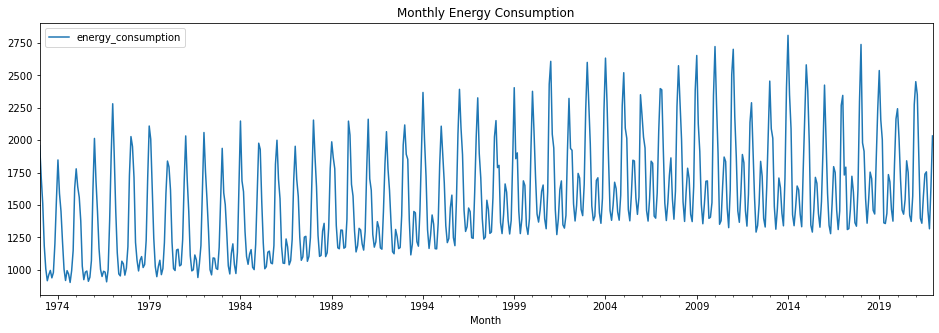

In [5]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [6]:
df.head()

,energy_consumption
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326


In [7]:
df.tail()

,energy_consumption
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [8]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [10]:
df.shape

(588, 1)

**Different ways to split your time series**


In [15]:
# using sklearn
from sklearn.model_selection import train_test_split
train, teset = train_test_split(df, test_size=24, shuffle=False)

# using sktime 
train, test = temporal_train_test_split(df, test_size=24)

# pandas slicing
size = 24
train, test = df.iloc[:-size], df.iloc[-size:]

train.columns = ['train']
test.columns = ['test']

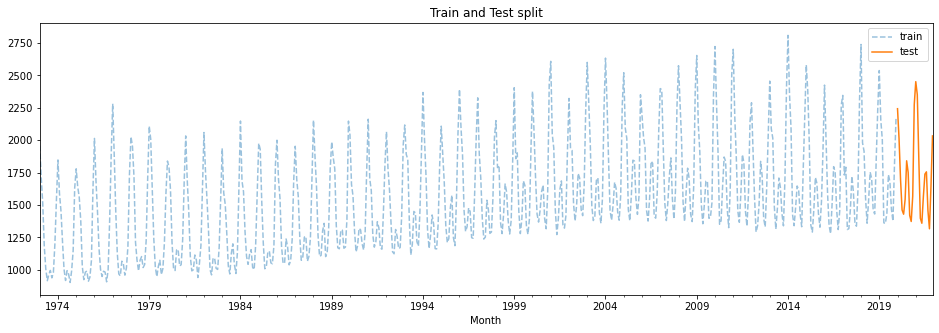

In [16]:
ax = train.plot(style='--', alpha=0.45)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [17]:
test.shape

(24, 1)

In [18]:
test.tail()

,test
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [19]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [20]:
adfuller(df)

(-1.449733113243752,
 0.5582151234544165,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

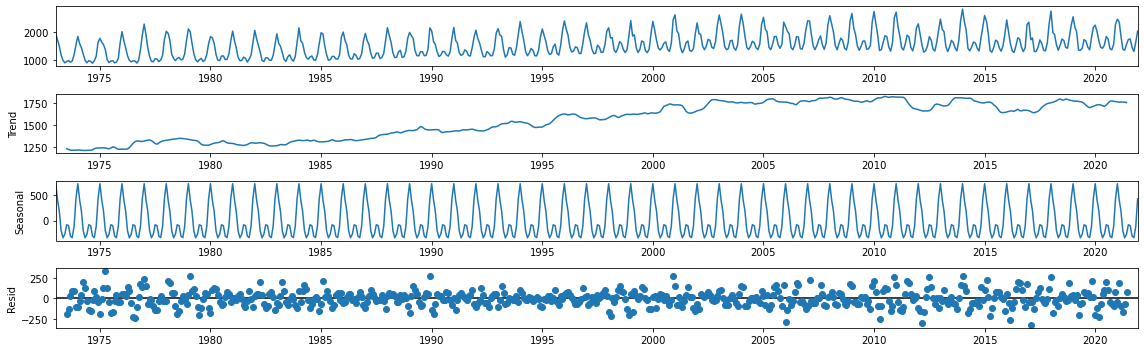

In [21]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [22]:
test.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [23]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    
    forecaster = [
        
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrebd", Detrender())
        
                ]
    
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            window_length=window
        ))
        
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)

    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [24]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor'
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [25]:
test.shape

(24, 6)

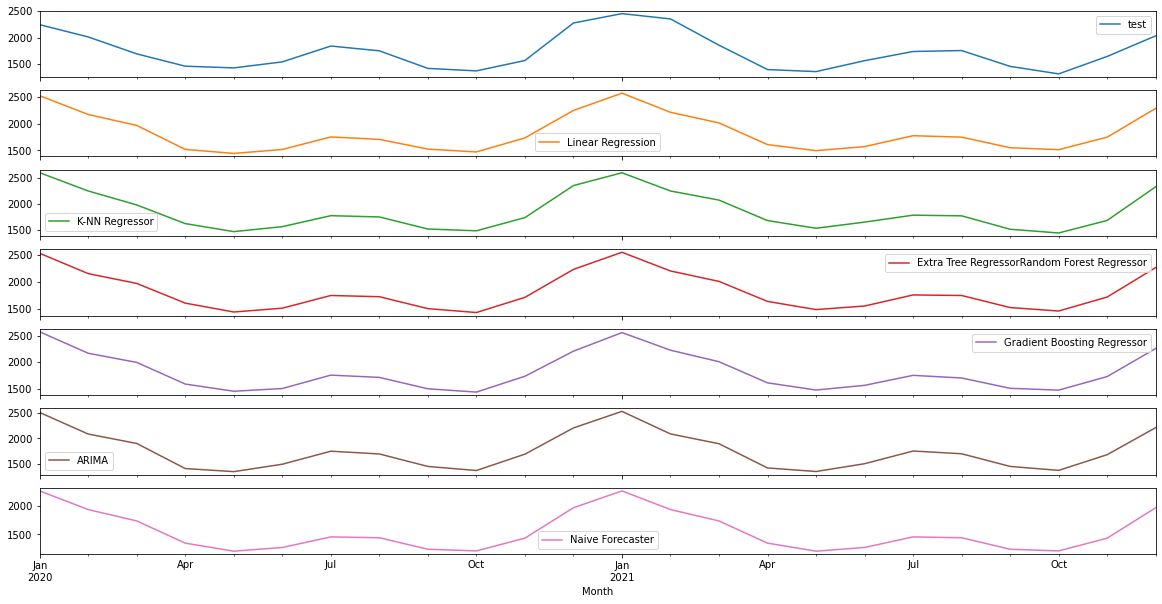

In [109]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

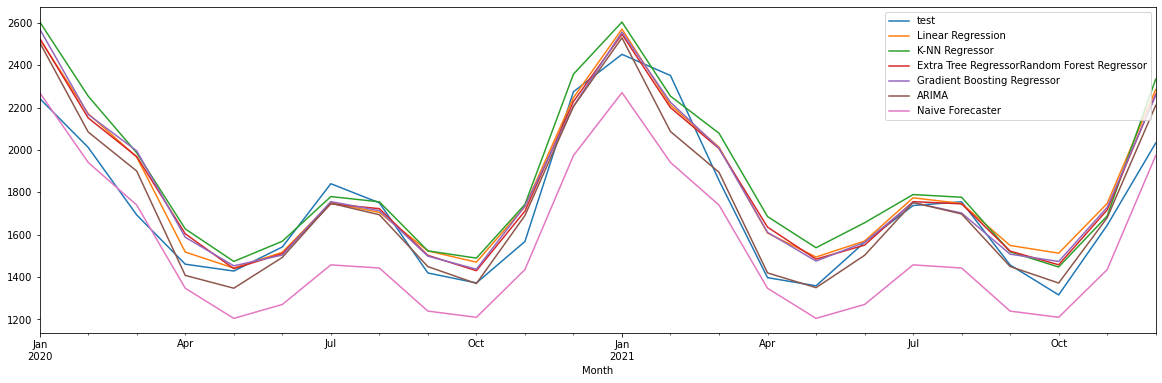

In [110]:
test.plot(subplots=False, figsize=(20, 6))

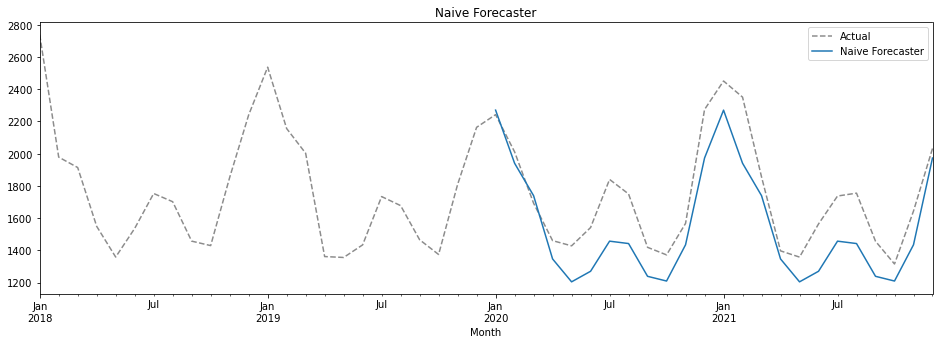

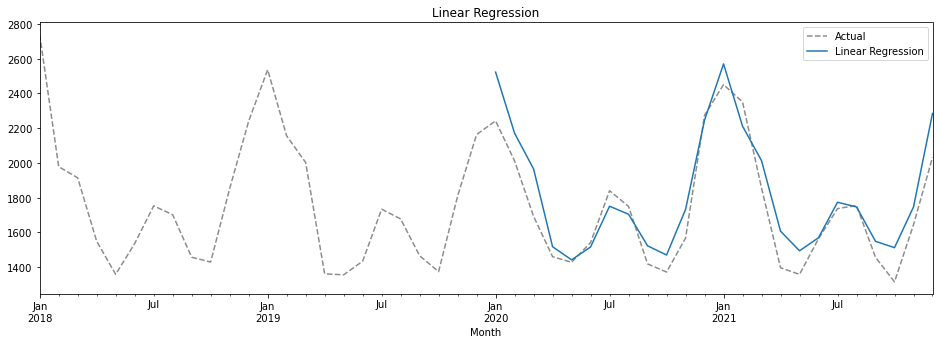

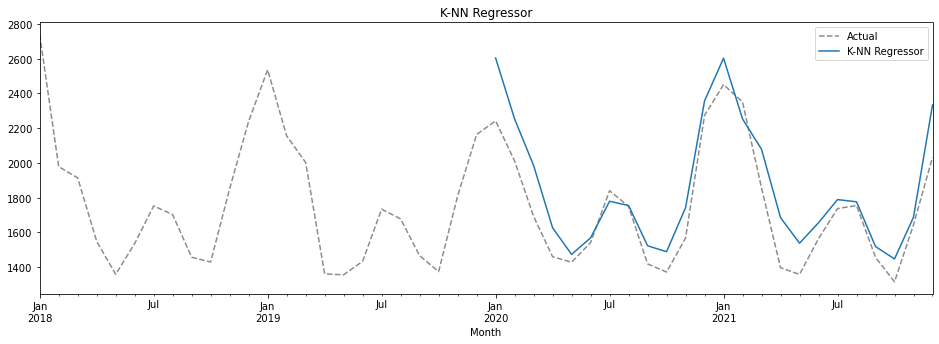

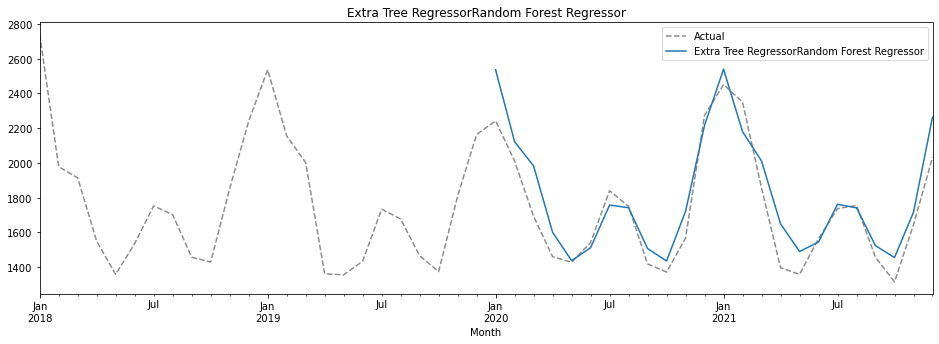

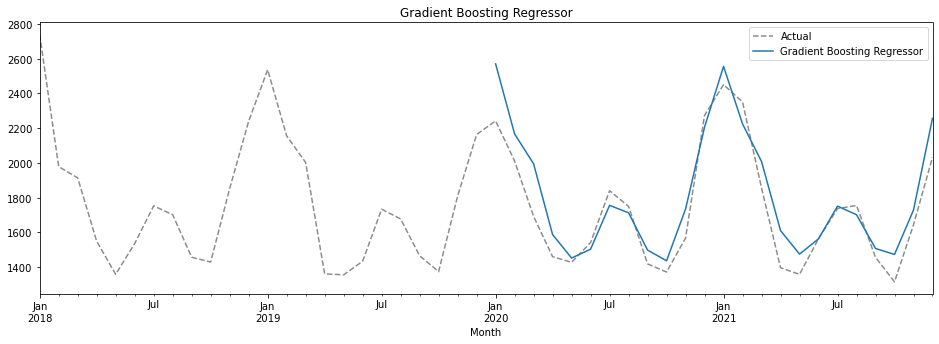

In [26]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [112]:
def evaluate(df, sort_by='sMAPE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['test']
    y_predicted = df.drop(columns=['test'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
    return evals.T.sort_values(by=sort_by)
    

In [113]:
evaluate(test)

,sMAPE,MAPE,RMSE
ARIMA,0.042925,0.043336,108.738816
Extra Tree RegressorRandom Forest Regressor,0.061810,0.064487,137.142558
Gradient Boosting Regressor,0.064285,0.067132,142.982248
Linear Regression,0.065325,0.068308,142.176939
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


In [114]:
evaluate(test, sort_by='RMSE')

,sMAPE,MAPE,RMSE
ARIMA,0.042925,0.043336,108.738816
Extra Tree RegressorRandom Forest Regressor,0.061810,0.064487,137.142558
Linear Regression,0.065325,0.068308,142.176939
Gradient Boosting Regressor,0.064285,0.067132,142.982248
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


In [96]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [97]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  564
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3338.554
Date:                                 Mon, 04 Apr 2022   AIC                           6691.108
Time:                                         03:58:38   BIC                           6721.441
Sample:                                              0   HQIC                          6702.949
                                                 - 564                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.006      0.106      0.916      -0.011       0.012
ar.L1          0.4767      0.034     14.071      0.000       0.410       0.543
ma.L1         -0.9748      0.010   -102.212      0.000      -0.993      -0.956
ar.S.L12       0.9978      0.002    612.650      0.000       0.995       1.001
ma.S.L12      -0.7217      0.028    -25.434      0.000      -0.777      -0.666
ma.S.L24      -0.0871      0.012     -7.308      0.000      -0.110      -0.064
sigma2      7804.8584    340.564     22.917      0.000    7137.366    8472.351
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                97.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
test['ARIMA'] = arima.predict(n)

In [99]:
test.shape

(24, 6)

In [100]:
test.head()

,test,Linear Regression,K-NN Regressor,Extra Tree RegressorRandom Forest Regressor,Gradient Boosting Regressor,ARIMA
Month,,,,,,
2020-01-01,2242.462,2522.814708,2604.277175,2517.815069,2570.473160,2506.947375
2020-02-01,2011.541,2171.116655,2253.460503,2132.764146,2166.817111,2084.300249
2020-03-01,1692.834,1965.760283,1985.997768,1964.326161,1986.086537,1900.006095
2020-04-01,1460.650,1517.825403,1627.154399,1596.695414,1587.730558,1407.773645
2020-05-01,1428.359,1442.385026,1473.659183,1449.238370,1452.865700,1347.337206


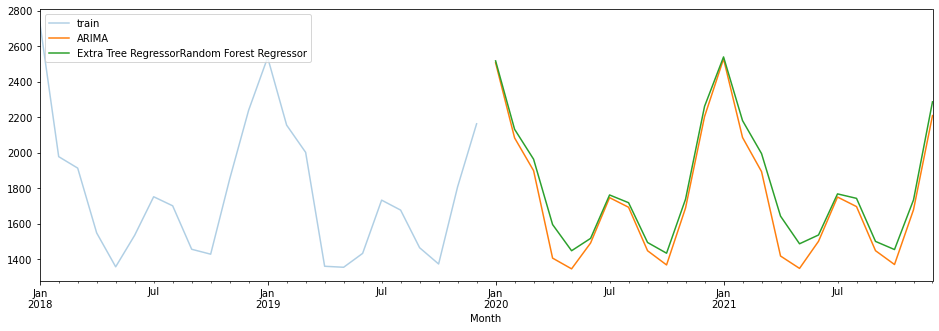

In [105]:
ax = train.loc['2018':].plot(style='-', alpha=0.35)
#test['Naive Forecaster'].plot(ax=ax)
test['ARIMA'].plot(ax=ax)
test['Extra Tree RegressorRandom Forest Regressor'].plot(ax=ax)
plt.legend()

In [ ]:
evaluate(test, sort_by='MAPE')

In [ ]:
evaluate(test, sort_by='RMSE')

# REcipe 2

In [82]:
from sktime.datasets import load_gunpoint
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [89]:
X, y = load_gunpoint(return_X_y=True)

In [92]:
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

In [93]:
x.shape
X_train.shape
y_train.shape

(150,)

In [147]:
X.shape

(200, 1)

In [137]:
from sktime.datatypes._panel._convert import from_long_to_nested, from_nested_to_long

In [138]:
X.head()

,dim_0
0,0 -0.647885 1 -0.641992 2 -0.63818...
1,0 -0.644427 1 -0.645401 2 -0.64705...
2,0 -0.778353 1 -0.778279 2 -0.77715...
3,0 -0.750060 1 -0.748103 2 -0.74616...
4,0 -0.599539 1 -0.597422 2 -0.59926...


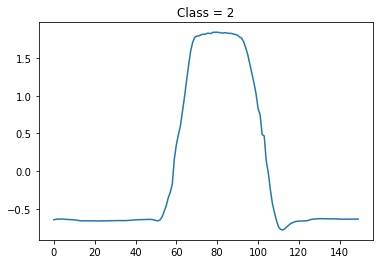

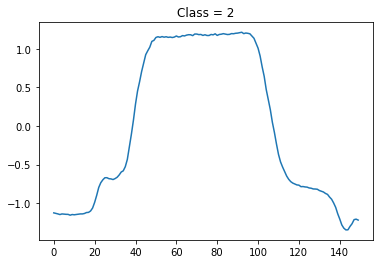

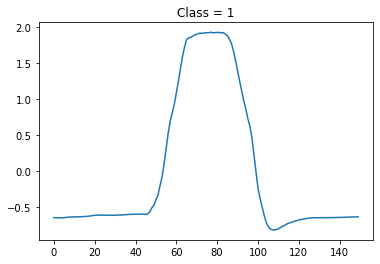

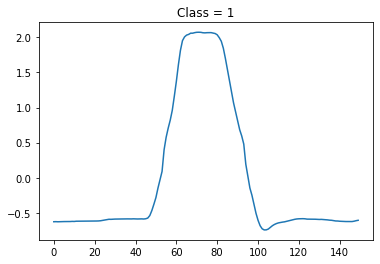

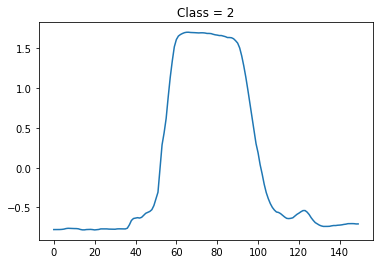

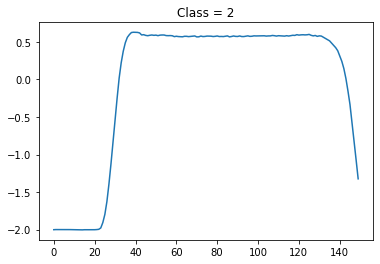

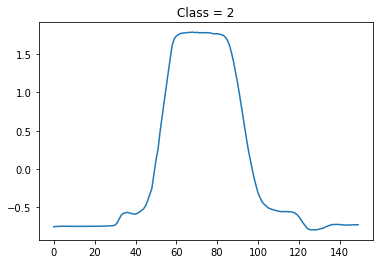

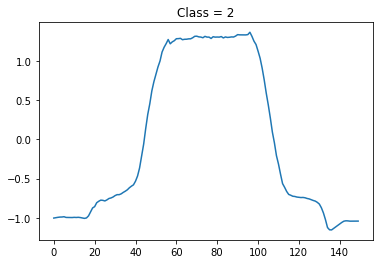

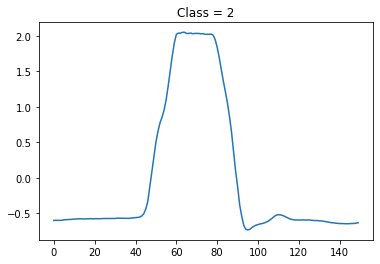

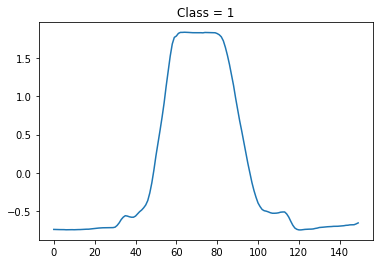

In [150]:
for i in range(10):
    from_nested_to_long(X)['value'][i].plot(title=f'Class = {y[i]}')
    plt.show()

In [136]:
from collections import Counter
Counter(y)

Counter({'2': 100, '1': 100})

In [98]:
knn = KNeighborsTimeSeriesClassifier()

In [99]:
knn.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier()

In [104]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [101]:
y_pred = knn.predict(X_test)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.96      0.91        25
           2       0.95      0.84      0.89        25

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



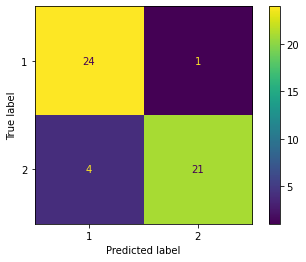

In [105]:
plot_confusion_matrix(knn, X_test, y_test)

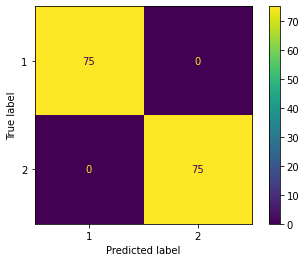

In [161]:
plot_confusion_matrix(knn, X_train, y_train)

In [162]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

In [ ]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
extracted_features = impute(extract_features(df_ts, column_id="id",
column_sort="time"))
#features_filtered = select_features(extracted_features, y)

Feature Extraction:   0%|                                                                                                                                                                | 0/20 [00:02<?, ?it/s]


ERROR! Session/line number was not unique in database. History logging moved to new session 1169


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import TransformedTargetForecaster
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape, median_squared_percentage_error as mspe
from sktime.forecasting.compose import RecursiveTimeSeriesRegressionForecaster, RecursiveTabularRegressionForecaster
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.compose import make_reduction

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate